In [13]:
import numpy as np
import pandas as pd
import h5py
import json
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import GradScaler, autocast
from torchinfo import summary
from typing import Tuple, Optional
import torch.utils.checkpoint as checkpoint
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm, trange
import seaborn as sns
import gc
import time 
import time
import warnings
from collections import deque
import psutil
import os
import math
import warnings
warnings.filterwarnings('ignore')

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [15]:
FILE_PATH = "/home/lipplopp/research/AMC_Repository/dataset/GOLD_XYZ_OSC.0001_1024.hdf5"
JSON_PATH = '/home/lipplopp/research/AMC_Repository/dataset/classes-fixed.json' 

TARGET_MODULATIONS = [
                      #'OOK',
                      # '4ASK',
                      '8ASK',
                      'BPSK', 
                      #'QPSK',
                      '8PSK', 
                      '16QAM',
                      '64QAM', 
                      #'OQPSK'
                     ]
## --- Training Hyperparameters ---
BATCH_SIZE = 64
NUM_EPOCHS = 100
patience = 10
NUM_CLASSES = len(TARGET_MODULATIONS)
NUM_WORKERS = 0

# --- Correctly define dataset split ratios ---
# These values will be passed to the stratified_dataset_split function.
TRAIN_SIZE = 0.7
VALID_SIZE = 0.2
TEST_SIZE = 0.1

print(f"Target Modulations: {TARGET_MODULATIONS}")
print("Training Parameters:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"Dataset Split Ratios:")
print(f"  Train: {TRAIN_SIZE*100:.0f}%, Validation: {VALID_SIZE*100:.0f}%, Test: {TEST_SIZE*100:.0f}%")

Target Modulations: ['8ASK', 'BPSK', '8PSK', '16QAM', '64QAM']
Training Parameters:
  Batch size: 64
  Epochs: 100
Dataset Split Ratios:
  Train: 70%, Validation: 20%, Test: 10%


In [16]:
file_path = FILE_PATH  # replace with your actual file path
print(f"File exists: {os.path.exists(file_path)}")
print(f"File size: {os.path.getsize(file_path)} bytes")

# Try opening the file directly
try:
    with h5py.File(file_path, 'r') as f:
        print("File opens successfully")
        print(f"Keys: {list(f.keys())}")
except Exception as e:
    print(f"Error opening file: {e}")

File exists: True
File size: 21449148312 bytes
File opens successfully
Keys: ['X', 'Y', 'Z']


In [17]:
def stratified_dataset_split(data, modulations, snrs, target_modulations,
                             train_size=0.7, valid_size=0.2, test_size=0.1,
                             seed=48, modulations_classes=None): # Added to handle the extra argument
    """
    Performs a stratified split of the dataset based on both modulation and SNR.

    This ensures that each split (train, validation, test) has a representative
    distribution of all classes and signal qualities.

    Args:
        data (np.ndarray): The full feature dataset (X).
        modulations (np.ndarray): The modulation labels (Y).
        snrs (np.ndarray): The SNR labels (Z).
        target_modulations (list): List of modulation names to include.
        train_size, valid_size, test_size (float): Proportions for the splits.
        seed (int): Random seed for reproducibility.
        modulations_classes (list, optional): Unused. Included for compatibility with older calls.

    Returns:
        A dictionary containing the split data:
        {'train': (X_train, Y_train, Z_train), ...}
    """
    # --- 1. Filter the data to include only target modulations ---
    # The modulations_classes argument is ignored, as this logic works directly with names.
    target_indices = np.where(np.isin(modulations, target_modulations))[0]
    
    X_filtered = data[target_indices]
    Y_filtered = modulations[target_indices]
    Z_filtered = snrs[target_indices]

    # --- 2. Create a combined stratification key ---
    # We want to stratify by both modulation AND SNR together.
    # We can create a unique string key for each combination.
    stratify_key = [f"{y}_{z}" for y, z in zip(Y_filtered, Z_filtered)]

    # --- 3. First Split: Separate the test set ---
    # This leaves us with a temporary set for train and validation
    X_train_val, X_test, Y_train_val, Y_test, Z_train_val, Z_test = train_test_split(
        X_filtered, Y_filtered, Z_filtered,
        test_size=test_size,
        random_state=seed,
        stratify=[f"{y}_{z}" for y, z in zip(Y_filtered, Z_filtered)] # Stratify by key
    )

    # --- 4. Second Split: Split the remainder into train and validation ---
    # The new valid_size needs to be recalculated as a proportion of the remaining data
    remaining_size = 1 - test_size # This is train_size + valid_size
    relative_valid_size = valid_size / remaining_size

    X_train, X_valid, Y_train, Y_valid, Z_train, Z_valid = train_test_split(
        X_train_val, Y_train_val, Z_train_val,
        test_size=relative_valid_size,
        random_state=seed,
        stratify=[f"{y}_{z}" for y, z in zip(Y_train_val, Z_train_val)] # Stratify again
    )
    
    # --- 5. Remap labels to be 0-indexed if necessary ---
    # (Your original code did this at the end, which is a good practice)
    # Create a mapping from the string name to an integer index
    label_map = {name: i for i, name in enumerate(target_modulations)}
    
    Y_train = np.array([label_map[y] for y in Y_train])
    Y_valid = np.array([label_map[y] for y in Y_valid])
    Y_test = np.array([label_map[y] for y in Y_test])

    return {
        'train': (X_train, Y_train, Z_train),
        'valid': (X_valid, Y_valid, Z_valid),
        'test': (X_test, Y_test, Z_test)
    }


In [35]:
class DualStreamRadioMLDataset(Dataset):
    def __init__(self, file_path, json_path, target_modulations,
                 train_size, valid_size, test_size,
                 mode: str, seed: int = 49, normalization_stats: dict = None):
        super(DualStreamRadioMLDataset, self).__init__()

        self.file_path = file_path
        self.json_path = json_path
        self.target_modulations = target_modulations
        self.mode = mode

        if mode not in ['train', 'valid', 'test']:
            raise ValueError(f"mode must be train, valid, or test, got '{mode}'")

        self.hdf5_file = h5py.File(self.file_path, 'r')
        self.X_h5 = self.hdf5_file['X']
        self.Y_int = np.argmax(self.hdf5_file['Y'][:], axis=1)
        self.Z = self.hdf5_file['Z'][:, 0]

        with open(self.json_path, 'r') as f:
            self.modulation_classes = json.load(f)

        self.Y_strings = np.array([self.modulation_classes[i] for i in self.Y_int])

        print("Performing stratified split on data indices...")
        self._perform_stratified_split(train_size, valid_size, test_size, seed)

        signal_length = self.X_h5.shape[1]
        if signal_length != 1024:
            raise ValueError(f"Expected signal length 1024, got {signal_length}")
        self.H, self.W = 32, 32

        if mode == 'train':
            print("Running in 'train' mode. Calculating normalization stats...")
            self.norm_stats = self._calculate_normalization_stats()
            print("Normalization stats calculated and stored.")
        elif normalization_stats is None:
            raise ValueError("normalization_stats must be provided for 'valid' or 'test' modes.")
        else:
            print(f"Running in '{mode}' mode. Using provided normalization stats.")
            self.norm_stats = normalization_stats

    def _perform_stratified_split(self, train_size, valid_size, test_size, seed):
        y_strings = np.array([self.modulation_classes[i] for i in self.Y_int])

        all_indices = np.arange(len(y_strings))
        target_mask = np.isin(y_strings, self.target_modulations)
        filtered_indices = all_indices[target_mask]

        y_filtered = y_strings[filtered_indices]
        z_filtered = self.Z[filtered_indices]
        stratify_key = [f"{y}_{z}" for y, z in zip(y_filtered, z_filtered)]

        train_val_indices, test_indices = train_test_split(
            filtered_indices, test_size=test_size, random_state=seed, stratify=stratify_key
        )

        y_train_val = y_strings[train_val_indices]
        z_train_val = self.Z[train_val_indices]
        stratify_key_tv = [f"{y}_{z}" for y, z in zip(y_train_val, z_train_val)]
        relative_valid_size = valid_size / (train_size + valid_size)
        train_indices, valid_indices = train_test_split(
            train_val_indices, test_size=relative_valid_size, random_state=seed, stratify=stratify_key_tv
        )

        # Convert indices to Python integers to avoid HDF5 indexing issues
        if self.mode == 'train':
            num_to_keep = int(0.2 * len(train_indices)) # Use 20% of the data
            train_indices = np.random.choice(train_indices, num_to_keep, replace=False)
            print(f"Subsampling training data to {num_to_keep} samples.")
        
        split_indices = {
            'train': train_indices,
            'valid': valid_indices,
            'test': test_indices
        }
        self.indices = split_indices[self.mode]

        self.label_map = {name: i for i, name in enumerate(self.target_modulations)}

    def __len__(self) -> int:
        return len(self.indices)

    def _calculate_normalization_stats(self):
        num_samples = min(5000, len(self.indices))
        sample_indices = np.random.choice(self.indices, num_samples, replace=False)
        
        # Convert to numpy array of integers for HDF5 indexing
        sample_indices = np.array(sample_indices, dtype=int)
        sorted_sample_indices = np.sort(sample_indices)
        
        sample_data = torch.from_numpy(self.X_h5[sorted_sample_indices, ...]).float()

        i_flat = sample_data[:, :, 0].flatten()
        q_flat = sample_data[:, :, 1].flatten()
        amplitude = torch.sqrt(i_flat**2 + q_flat**2)

        stats = {
            'i_mean': i_flat.mean().item(), 'i_std': i_flat.std().item(),
            'q_mean': q_flat.mean().item(), 'q_std': q_flat.std().item(),
            'amp_max': amplitude.max().item()
        }
        return stats

    def __getitem__(self, idx: int):
        true_index = self.indices[idx]
        
        # Ensure index is a Python integer for HDF5 compatibility
        x_raw = self.X_h5[int(true_index)]
        
        y_string = self.Y_strings[true_index]
        y = int(self.label_map[y_string])
        z = float(self.Z[true_index])

        iq_sequence = torch.from_numpy(x_raw).float()
        iq_sequence[:, 0] = (iq_sequence[:, 0] - self.norm_stats['i_mean']) / self.norm_stats['i_std']
        iq_sequence[:, 1] = (iq_sequence[:, 1] - self.norm_stats['q_mean']) / self.norm_stats['q_std']

        i_signal = iq_sequence[:, 0]
        q_signal = iq_sequence[:, 1]
        amplitude = torch.sqrt(i_signal**2 + q_signal**2)
        phase = torch.atan2(q_signal, i_signal)

        amplitude_2d = amplitude.view(1, self.H, self.W)
        phase_2d = phase.view(1, self.H, self.W)

        amplitude_2d = amplitude_2d / self.norm_stats['amp_max']
        phase_2d = phase_2d / math.pi
        
        return amplitude_2d, phase_2d, iq_sequence, y, z

    def close(self):
        if hasattr(self, 'hdf5_file') and self.hdf5_file is not None:
            try:
                self.hdf5_file.close()
                print("HDF5 file closed.")
            except:
                pass  # File might already be closed
            finally:
                self.hdf5_file = None

    def __del__(self):
        self.close()

In [36]:
# class DualStreamRadioMLDataset(Dataset):
#     def __init__(self, file_path, json_path, target_modulations,
#                  train_size, valid_size, test_size,
#                  mode: str, seed: int = 49, normalization_stats: dict = None):
#         super(DualStreamRadioMLDataset, self).__init__()

#         self.file_path = file_path
#         self.json_path = json_path
#         self.target_modulations = target_modulations
#         self.mode = mode

#         if mode not in ['train', 'valid', 'test']:
#             raise ValueError(f"mode must be train, valid, or test, got '{mode}'")

#         self.hdf5_file = h5py.File(self.file_path, 'r')
#         self.X_h5 = self.hdf5_file['X']
#         self.Y_int = np.argmax(self.hdf5_file['Y'][:], axis=1)
#         self.Z = self.hdf5_file['Z'][:, 0]

#         with open(self.json_path, 'r') as f:
#             self.modulation_classes = json.load(f)

#         self.Y_strings = np.array([self.modulation_classes[i] for i in self.Y_int])

#         print("Performing stratified split on data indices...")
#         self._perform_stratified_split(train_size, valid_size, test_size, seed)

#         signal_length = self.X_h5.shape[1]
#         if signal_length != 1024:
#             raise ValueError(f"Expected signal length 1024, got {signal_length}")
#         self.H, self.W = 32, 32

#         if mode == 'train':
#             print("Running in 'train' mode. Calculating normalization stats...")
#             self.norm_stats = self._calculate_normalization_stats()
#             print("Normalization stats calculated and stored.")
#         elif normalization_stats is None:
#             raise ValueError("normalization_stats must be provided for 'valid' or 'test' modes.")
#         else:
#             print(f"Running in '{mode}' mode. Using provided normalization stats.")
#             self.norm_stats = normalization_stats

#     def _perform_stratified_split(self, train_size, valid_size, test_size, seed):
#         y_strings = np.array([self.modulation_classes[i] for i in self.Y_int])

#         all_indices = np.arange(len(y_strings))
#         target_mask = np.isin(y_strings, self.target_modulations)
#         filtered_indices = all_indices[target_mask]

#         y_filtered = y_strings[filtered_indices]
#         z_filtered = self.Z[filtered_indices]
#         stratify_key = [f"{y}_{z}" for y, z in zip(y_filtered, z_filtered)]

#         train_val_indices, test_indices = train_test_split(
#             filtered_indices, test_size=test_size, random_state=seed, stratify=stratify_key
#         )

#         y_train_val = y_strings[train_val_indices]
#         z_train_val = self.Z[train_val_indices]
#         stratify_key_tv = [f"{y}_{z}" for y, z in zip(y_train_val, z_train_val)]
#         relative_valid_size = valid_size / (train_size + valid_size)
#         train_indices, valid_indices = train_test_split(
#             train_val_indices, test_size=relative_valid_size, random_state=seed, stratify=stratify_key_tv
#         )

#         # Convert indices to Python integers to avoid HDF5 indexing issues
#         split_indices = {
#             'train': [int(i) for i in train_indices],
#             'valid': [int(i) for i in valid_indices],
#             'test': [int(i) for i in test_indices]
#         }
#         self.indices = split_indices[self.mode]

#         self.label_map = {name: i for i, name in enumerate(self.target_modulations)}

#     def __len__(self) -> int:
#         return len(self.indices)

#     def _calculate_normalization_stats(self):
#         num_samples = min(5000, len(self.indices))
#         sample_indices = np.random.choice(self.indices, num_samples, replace=False)
        
#         # Convert to numpy array of integers for HDF5 indexing
#         sample_indices = np.array(sample_indices, dtype=int)
#         sorted_sample_indices = np.sort(sample_indices)
        
#         sample_data = torch.from_numpy(self.X_h5[sorted_sample_indices, ...]).float()

#         i_flat = sample_data[:, :, 0].flatten()
#         q_flat = sample_data[:, :, 1].flatten()
#         amplitude = torch.sqrt(i_flat**2 + q_flat**2)

#         stats = {
#             'i_mean': i_flat.mean().item(), 'i_std': i_flat.std().item(),
#             'q_mean': q_flat.mean().item(), 'q_std': q_flat.std().item(),
#             'amp_max': amplitude.max().item()
#         }
#         return stats

#     def __getitem__(self, idx: int):
#         true_index = self.indices[idx]
        
#         # Ensure index is a Python integer for HDF5 compatibility
#         x_raw = self.X_h5[int(true_index)]
        
#         y_string = self.Y_strings[true_index]
#         y = int(self.label_map[y_string])
#         z = float(self.Z[true_index])

#         iq_sequence = torch.from_numpy(x_raw).float()
#         iq_sequence[:, 0] = (iq_sequence[:, 0] - self.norm_stats['i_mean']) / self.norm_stats['i_std']
#         iq_sequence[:, 1] = (iq_sequence[:, 1] - self.norm_stats['q_mean']) / self.norm_stats['q_std']

#         i_signal = iq_sequence[:, 0]
#         q_signal = iq_sequence[:, 1]
#         amplitude = torch.sqrt(i_signal**2 + q_signal**2)
#         phase = torch.atan2(q_signal, i_signal)

#         amplitude_2d = amplitude.view(1, self.H, self.W)
#         phase_2d = phase.view(1, self.H, self.W)

#         amplitude_2d = amplitude_2d / self.norm_stats['amp_max']
#         phase_2d = phase_2d / math.pi
        
#         return amplitude_2d, phase_2d, iq_sequence, y, z

#     def close(self):
#         if hasattr(self, 'hdf5_file'):
#             self.hdf5_file.close()
#             print("HDF5 file closed.")

#     def __del__(self):
#         self.close()

In [37]:
try:
    dataset = DualStreamRadioMLDataset(
        file_path=FILE_PATH,
        json_path=JSON_PATH,
        target_modulations=TARGET_MODULATIONS,
        train_size=TRAIN_SIZE,
        valid_size=VALID_SIZE,
        test_size=TEST_SIZE,
        mode='train'
    )
    print("Dataset initialized successfully!")
except Exception as e:
    print(f"Error initializing dataset: {e}")
    import traceback
    traceback.print_exc()

Performing stratified split on data indices...
Subsampling training data to 74547 samples.
Running in 'train' mode. Calculating normalization stats...
Normalization stats calculated and stored.
HDF5 file closed.
Dataset initialized successfully!


In [38]:
try:
    print(f"Dataset length: {len(dataset)}")
except Exception as e:
    print(f"Error getting length: {e}")

Dataset length: 74547


In [39]:
try:
    item = dataset[0]  # Get first item
    print(f"Item types: {[type(x) for x in item]}")
    print(f"Item shapes: {[x.shape if hasattr(x, 'shape') else 'scalar' for x in item]}")
except Exception as e:
    print(f"Error getting item: {e}")
    import traceback
    traceback.print_exc()

Item types: [<class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'torch.Tensor'>, <class 'int'>, <class 'float'>]
Item shapes: [torch.Size([1, 32, 32]), torch.Size([1, 32, 32]), torch.Size([1024, 2]), 'scalar', 'scalar']


In [40]:
try:
    dataset.close()
    print("Dataset closed successfully!")
except Exception as e:
    print(f"Error closing dataset: {e}")

HDF5 file closed.
Dataset closed successfully!


In [41]:
from torch.utils.data import DataLoader

try:
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
    batch = next(iter(dataloader))
    print(f"Batch types: {[type(x) for x in batch]}")
    print(f"Batch shapes: {[x.shape for x in batch]}")
except Exception as e:
    print(f"Error with dataloader: {e}")
    import traceback
    traceback.print_exc()

Error with dataloader: Can't synchronously read data (identifier is not of specified type)


Traceback (most recent call last):
  File "/tmp/ipykernel_669159/705975352.py", line 5, in <module>
    batch = next(iter(dataloader))
            ^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda/envs/tesisnich/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 734, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/opt/anaconda/envs/tesisnich/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 790, in _next_data
    data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda/envs/tesisnich/lib/python3.12/site-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
            ~~~~~~~~~~~~^^^^^
  File "/tmp/ipykernel_669159/1560575891.py", line 109, in __getitem__
    x_raw = self.X_h5[int(true_index)]
            ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "h5py/_objects.pyx", line 56, in h5py._

In [42]:
try:
    from CNN_LSTM_new import create_multi_domain_model
    model_new = create_multi_domain_model(num_classes=NUM_CLASSES, dropout_rate=0.7).to(device)
    print("✅ Successfully built Parallel CNN-LSTM Model")
except Exception as e:
    print(f"⚠️ Could not build Multi domain Model: {e}")

✅ Successfully built Parallel CNN-LSTM Model


In [43]:
from torchinfo import summary 
summary(model_new) 

Layer (type:depth-idx)                   Param #
MultiDomainFusionModel                   --
├─Cnn2DBranch: 1-1                       --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  640
│    │    └─BatchNorm2d: 3-2             128
│    │    └─LeakyReLU: 3-3               --
│    │    └─Conv2d: 3-4                  73,856
│    │    └─BatchNorm2d: 3-5             256
│    │    └─LeakyReLU: 3-6               --
│    │    └─MaxPool2d: 3-7               --
│    │    └─Dropout2d: 3-8               --
│    │    └─Conv2d: 3-9                  295,168
│    │    └─BatchNorm2d: 3-10            512
│    │    └─LeakyReLU: 3-11              --
│    │    └─MaxPool2d: 3-12              --
│    │    └─Dropout2d: 3-13              --
│    └─AdaptiveAvgPool2d: 2-2            --
├─Cnn2DBranch: 1-2                       --
│    └─Sequential: 2-3                   --
│    │    └─Conv2d: 3-14                 640
│    │    └─BatchNorm2d: 3-15            128
│    │    └─

In [44]:
def debug_model_with_dataset():
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Initialize dataset
    dataset = DualStreamRadioMLDataset(
        file_path=FILE_PATH,
        json_path=JSON_PATH,
        target_modulations=TARGET_MODULATIONS,
        train_size=TRAIN_SIZE,
        valid_size=VALID_SIZE,
        test_size=TEST_SIZE,
        mode='train'
    )
    
    print(f"Dataset size: {len(dataset)}")
    
    # Create a DataLoader
    dataloader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    # Get a sample batch
    batch = next(iter(dataloader))
    amplitude_2d, phase_2d, iq_sequence, y, z = batch
    
    print("Batch shapes:")
    print(f"Amplitude: {amplitude_2d.shape}")
    print(f"Phase: {phase_2d.shape}")
    print(f"IQ Sequence: {iq_sequence.shape}")
    print(f"Labels: {y.shape}")
    print(f"SNRs: {z.shape}")
    
    # Initialize model
    num_classes = len(dataset.target_modulations)
    model = model_new
    model = model.to(device)
    
    print(f"Model created with {num_classes} classes")
    
    # Move batch to device
    amplitude_2d = amplitude_2d.to(device)
    phase_2d = phase_2d.to(device)
    iq_sequence = iq_sequence.to(device)
    
    # Test forward pass
    try:
        with torch.no_grad():
            output = model(amplitude_2d, phase_2d, iq_sequence)
            print(f"Model output shape: {output.shape}")
            print(f"Model output: {output}")
            
            # Test loss calculation
            criterion = nn.CrossEntropyLoss()
            y = y.to(device)
            loss = criterion(output, y)
            print(f"Loss: {loss.item()}")
            
    except Exception as e:
        print(f"Error during forward pass: {e}")
        import traceback
        traceback.print_exc()
    
    # Test backpropagation
    try:
        amplitude_2d.requires_grad_(True)
        phase_2d.requires_grad_(True)
        iq_sequence.requires_grad_(True)
        
        output = model(amplitude_2d, phase_2d, iq_sequence)
        loss = criterion(output, y)
        loss.backward()
        
        print("Backward pass completed successfully")
        print(f"Amplitude gradients: {amplitude_2d.grad is not None}")
        print(f"Phase gradients: {phase_2d.grad is not None}")
        print(f"IQ Sequence gradients: {iq_sequence.grad is not None}")
        
    except Exception as e:
        print(f"Error during backward pass: {e}")
        import traceback
        traceback.print_exc()
    
    return model, dataset

In [45]:
model, dataset = debug_model_with_dataset()

Using device: cuda
Performing stratified split on data indices...
Subsampling training data to 74547 samples.
Running in 'train' mode. Calculating normalization stats...
Normalization stats calculated and stored.
Dataset size: 74547
Batch shapes:
Amplitude: torch.Size([4, 1, 32, 32])
Phase: torch.Size([4, 1, 32, 32])
IQ Sequence: torch.Size([4, 1024, 2])
Labels: torch.Size([4])
SNRs: torch.Size([4])
Model created with 5 classes
Model output shape: torch.Size([4, 5])
Model output: tensor([[-0.1279,  0.2621, -0.1613,  0.6198,  0.4348],
        [-0.2212, -0.3536,  0.7648, -0.1966, -0.0145],
        [-0.8563, -0.2989,  0.5979,  0.1016, -0.1584],
        [ 0.0717,  0.1455, -0.4033, -0.6961,  0.1328]], device='cuda:0')
Loss: 1.9621498584747314
Backward pass completed successfully
Amplitude gradients: True
Phase gradients: True
IQ Sequence gradients: True


In [46]:
# Optimizers for both models
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer_new = optim.AdamW(
    model_new.parameters(), 
    lr=1e-3,
    weight_decay=1e-4,
    betas=(0.9, 0.99)
)

# Schedulers for both models
scheduler_new = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_new, 
    mode='max',           # Monitor accuracy
    patience=5,           # Wait for 5 epochs without improvement
    factor=0.5,           # Reduce LR by half
    min_lr=1e-6,          # Minimum learning rate
    #verbose=True          # Print updates
)

# Scalers for mixed precision
scaler_new = GradScaler(
    init_scale=2.**10,  # Higher initial scale for quantum gradients
    growth_interval=100  # Less frequent scaling updates
)


In [47]:
# --- Data Loaders ---
print("\n📂 Loading datasets...")
train_dataset = DualStreamRadioMLDataset(
        file_path=FILE_PATH,
        json_path=JSON_PATH,
        target_modulations=TARGET_MODULATIONS,
        train_size=TRAIN_SIZE,
        valid_size=VALID_SIZE,
        test_size=TEST_SIZE,
        mode='train'
    )
train_norm_stats = train_dataset.norm_stats
print(f"Stats to be used for validation and test sets: {train_norm_stats}")
valid_dataset = DualStreamRadioMLDataset(
        file_path=FILE_PATH,
        json_path=JSON_PATH,
        target_modulations=TARGET_MODULATIONS,
        train_size=TRAIN_SIZE,
        valid_size=VALID_SIZE,
        test_size=TEST_SIZE,
        mode='valid',
        normalization_stats = train_norm_stats
    )
test_dataset = DualStreamRadioMLDataset(
        file_path=FILE_PATH,
        json_path=JSON_PATH,
        target_modulations=TARGET_MODULATIONS,
        train_size=TRAIN_SIZE,
        valid_size=VALID_SIZE,
        test_size=TEST_SIZE,
        mode='test',
        normalization_stats = train_norm_stats
    )

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, 
    pin_memory=True, num_workers=4, persistent_workers=True
)

valid_loader = DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    pin_memory=True, num_workers=4, persistent_workers=True
)

test_loader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=False, 
    pin_memory=True, num_workers=4, persistent_workers=True
)

print(f"Train dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"test dataset size: {len(test_dataset)}")


📂 Loading datasets...
Performing stratified split on data indices...
Subsampling training data to 74547 samples.
Running in 'train' mode. Calculating normalization stats...
Normalization stats calculated and stored.
Stats to be used for validation and test sets: {'i_mean': -0.0035014136228710413, 'i_std': 0.8006687760353088, 'q_mean': 0.009975148364901543, 'q_std': 0.8084979057312012, 'amp_max': 4.5027642250061035}
Performing stratified split on data indices...
Running in 'valid' mode. Using provided normalization stats.
Performing stratified split on data indices...
Running in 'test' mode. Using provided normalization stats.
HDF5 file closed.
HDF5 file closed.
HDF5 file closed.
Train dataset size: 74547
Validation dataset size: 106497
test dataset size: 53248


In [48]:
metrics = {
    'train_losses': [], 'valid_losses': [],
    'train_accuracies': [], 'valid_accuracies': [],
    'training_times': [], 'best_accuracy': 0.0,
    'final_predictions': [], 'final_true_labels': []
}
patience_counter = 0
best_model_state = None
scaler = GradScaler()

In [49]:
def train_epoch(model, train_loader, optimizer, criterion, scaler, device):
    """
    Train one epoch with the new multi-domain model.
    Handles three data inputs from the dataloader.
    """
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    start_time = time.time()
    
    # --- ADJUSTMENT 1: Unpack the new data format ---
    # The dataloader now yields 5 items. We need the first 4.
    for amp_inputs, phase_inputs, iq_seq_inputs, labels, _ in train_loader:
        # --- ADJUSTMENT 2: Move all required tensors to the device ---
        amp_inputs = amp_inputs.to(device)
        phase_inputs = phase_inputs.to(device)
        iq_seq_inputs = iq_seq_inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        with autocast():
            # --- ADJUSTMENT 3: Call the model with three inputs ---
            outputs = model(amp_inputs, phase_inputs, iq_seq_inputs)
            loss = criterion(outputs, labels)
        
        # Mixed-precision training steps (unchanged)
        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        
        # Metrics calculation (unchanged)
        running_loss += loss.item() * amp_inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_time = time.time() - start_time
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy, epoch_time

def validate_epoch(model, valid_loader, criterion, device):
    """
    Validate one epoch with the new multi-domain model.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        # --- ADJUSTMENT 1: Unpack the new data format ---
        for amp_inputs, phase_inputs, iq_seq_inputs, labels, _ in valid_loader:
            # --- ADJUSTMENT 2: Move all required tensors to the device ---
            amp_inputs = amp_inputs.to(device)
            phase_inputs = phase_inputs.to(device)
            iq_seq_inputs = iq_seq_inputs.to(device)
            labels = labels.to(device)
            
            # --- ADJUSTMENT 3: Call the model with three inputs ---
            outputs = model(amp_inputs, phase_inputs, iq_seq_inputs)
            loss = criterion(outputs, labels)
            
            # Metrics calculation (unchanged)
            running_loss += loss.item() * amp_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    epoch_loss = running_loss / len(valid_loader.dataset)
    epoch_accuracy = 100. * correct / total
    
    return epoch_loss, epoch_accuracy, predictions, true_labels

def test_epoch(model, test_loader, criterion, device):
    """
    Test one epoch with the new multi-domain model and a progress bar.
    """
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    predictions = []
    true_labels = []
    
    test_iterator = tqdm(test_loader, desc="Testing", leave=False, ncols=100)
    
    with torch.no_grad():
        # --- ADJUSTMENT 1: Unpack the new data format ---
        for amp_inputs, phase_inputs, iq_seq_inputs, labels, _ in test_iterator:
            # --- ADJUSTMENT 2: Move all required tensors to the device ---
            amp_inputs = amp_inputs.to(device)
            phase_inputs = phase_inputs.to(device)
            iq_seq_inputs = iq_seq_inputs.to(device)
            labels = labels.to(device)
            
            # --- ADJUSTMENT 3: Call the model with three inputs ---
            outputs = model(amp_inputs, phase_inputs, iq_seq_inputs)
            loss = criterion(outputs, labels)
            
            # Metrics calculation (unchanged)
            running_loss += loss.item() * amp_inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            predictions.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
            # Update progress bar
            avg_loss = running_loss / total
            accuracy = 100. * correct / total
            test_iterator.set_postfix(loss=f"{avg_loss:.4f}", accuracy=f"{accuracy:.2f}%")

    epoch_loss = running_loss / len(test_loader.dataset)
    epoch_accuracy = 100. * correct / total

    return epoch_loss, epoch_accuracy, predictions, true_labels

In [50]:
# --- Simplified Training Loop ---
import copy
import time
print("\n🎯 Starting model training...")
print("=" * 80)

for epoch in tqdm(range(NUM_EPOCHS), desc="Training Progress"):
    epoch_start = time.time()
    
    # --- Train the model ---
    # The train_epoch function is the adjusted one that handles 3 data inputs
    train_loss, train_acc, train_time = train_epoch(
        model_new, train_loader, optimizer_new, criterion, scaler_new, device
    )
    
    # --- Validate the model ---
    # The validate_epoch function is also the adjusted one
    valid_loss, valid_acc, predictions, true_labels = validate_epoch(
        model_new, valid_loader, criterion, device
    )
    
    # --- Update the flattened metrics dictionary ---
    metrics['train_losses'].append(train_loss)
    metrics['train_accuracies'].append(train_acc)
    metrics['valid_losses'].append(valid_loss)
    metrics['valid_accuracies'].append(valid_acc)
    metrics['training_times'].append(train_time)
    
    # --- Update scheduler (if you have one) ---
    # scheduler_parallel.step()
    
    # --- Check for best model and handle early stopping ---
    if valid_acc > metrics['best_accuracy']:
        metrics['best_accuracy'] = valid_acc
        # The validation function already returns numpy arrays
        metrics['final_predictions'] = predictions
        metrics['final_true_labels'] = true_labels
        # Save the best model's state
        best_model_state = copy.deepcopy(model_new.state_dict())
        patience_counter = 0 # Reset patience
    else:
        patience_counter += 1
    
    # --- Print epoch results ---
    if (epoch + 1) % 5 == 0:
        print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}:")
        print(f"Train Acc: {train_acc:.2f}% | Valid Acc: {valid_acc:.2f}% | Time: {train_time:.2f}s")
    
    # --- Early stopping check ---
    if patience_counter >= patience:
        print(f"\nEarly stopping at epoch {epoch+1} - Model has not improved for {patience} epochs.")
        break

print("\n🎉 Training Complete!")
print(f"Best Validation Accuracy: {metrics['best_accuracy']:.2f}%")

# --- Final Testing on Test Set ---
# Check if a test_loader and a saved best model exist
if 'test_loader' in locals() and best_model_state is not None:
    print("\n🔍 Final testing on the test set with the best model...")
    
    # Load the best model's weights
    model_new.load_state_dict(best_model_state)
    
    # Test the model
    test_loss, test_acc, test_predictions, test_true_labels = test_epoch(
        model_new, test_loader, criterion, device
    )
    
    # Store the final test results
    metrics['test_accuracy'] = test_acc
    metrics['test_loss'] = test_loss
    metrics['test_predictions'] = test_predictions
    metrics['test_true_labels'] = test_true_labels
    
    print(f"Final Test Accuracy: {test_acc:.2f}%")
else:
    print("\n⚠️ No test_loader found or model did not improve - skipping final testing.")


🎯 Starting model training...


Training Progress:   5%| | 5/100 [12:08<3:


Epoch 5/100:
Train Acc: 62.70% | Valid Acc: 63.40% | Time: 90.14s


Training Progress:  10%| | 10/100 [24:37<3


Epoch 10/100:
Train Acc: 64.31% | Valid Acc: 65.03% | Time: 90.09s


Training Progress:  15%|▏| 15/100 [37:05<3


Epoch 15/100:
Train Acc: 65.54% | Valid Acc: 66.39% | Time: 90.05s


Training Progress:  20%|▏| 20/100 [49:34<3


Epoch 20/100:
Train Acc: 68.57% | Valid Acc: 62.71% | Time: 90.05s


Training Progress:  25%|▎| 25/100 [1:02:02


Epoch 25/100:
Train Acc: 71.48% | Valid Acc: 68.90% | Time: 90.07s


Training Progress:  30%|▎| 30/100 [1:14:31


Epoch 30/100:
Train Acc: 72.34% | Valid Acc: 64.25% | Time: 89.92s


Training Progress:  35%|▎| 35/100 [1:26:59


Epoch 35/100:
Train Acc: 72.75% | Valid Acc: 69.23% | Time: 90.03s


Training Progress:  40%|▍| 40/100 [1:39:27


Epoch 40/100:
Train Acc: 73.20% | Valid Acc: 73.37% | Time: 89.91s


Training Progress:  45%|▍| 45/100 [1:51:53


Epoch 45/100:
Train Acc: 73.70% | Valid Acc: 72.73% | Time: 89.79s


Training Progress:  49%|▍| 49/100 [2:04:21



Epoch 50/100:
Train Acc: 74.35% | Valid Acc: 65.29% | Time: 89.98s

Early stopping at epoch 50 - Model has not improved for 10 epochs.

🎉 Training Complete!
Best Validation Accuracy: 73.37%

🔍 Final testing on the test set with the best model...


Final Test Accuracy: 73.22%


HDF5 file closed.


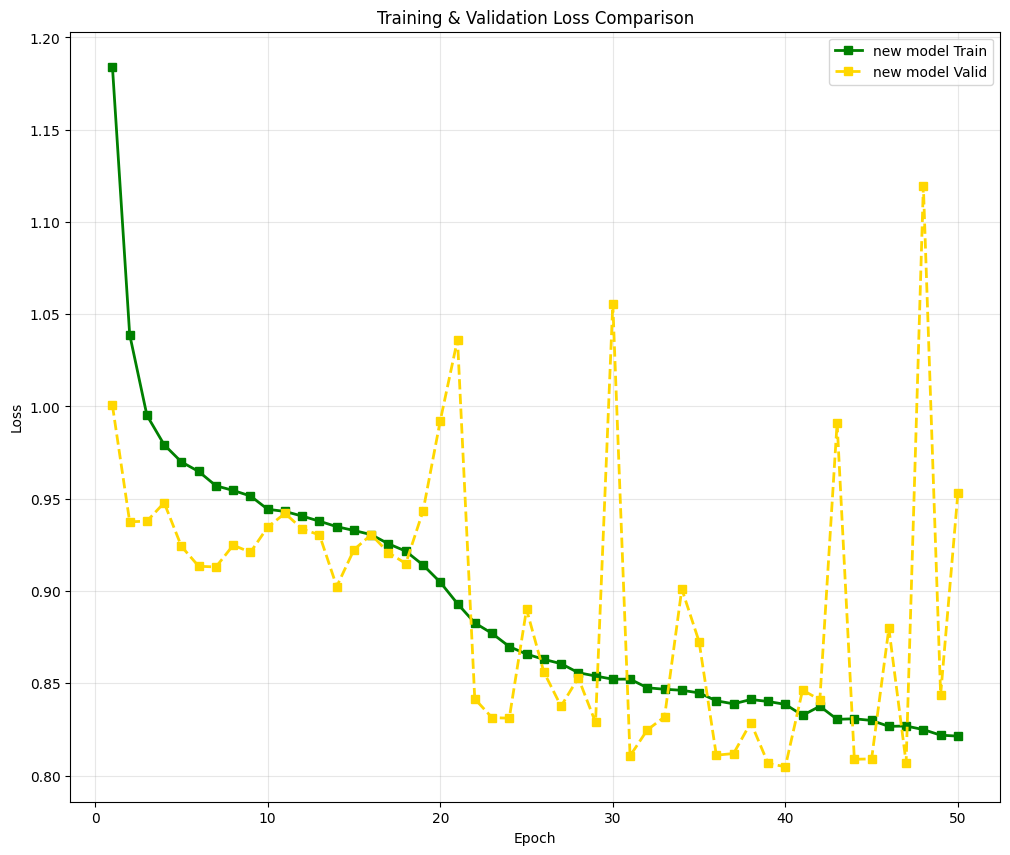

In [52]:
plt.figure(figsize=(12, 10), dpi=100)
epochs = range(1, len(metrics['train_losses']) + 1)
plt.plot(epochs, metrics['train_losses'], 'r-', label='new model Train', linewidth=2, marker = 's', color = 'green')
plt.plot(epochs, metrics['valid_losses'], 'r--', label='new model Valid', linewidth=2,marker = 's', color = 'gold')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training & Validation Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

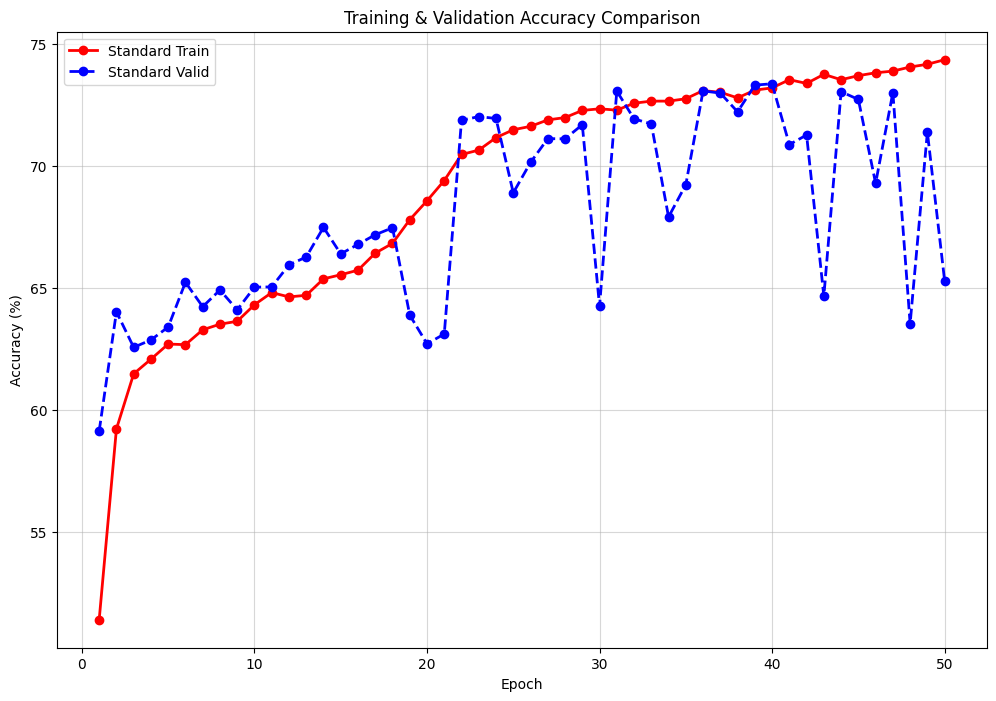

In [53]:
plt.figure(figsize=(12, 8), dpi=100)
plt.plot(epochs, metrics['train_accuracies'], 'b-', label='Standard Train', linewidth=2,color = 'red',marker = 'o')
plt.plot(epochs, metrics['valid_accuracies'], 'b--', label='Standard Valid', linewidth=2,color = 'blue', marker = 'o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training & Validation Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.5)

Text(50.722222222222214, 0.5, 'Actual')

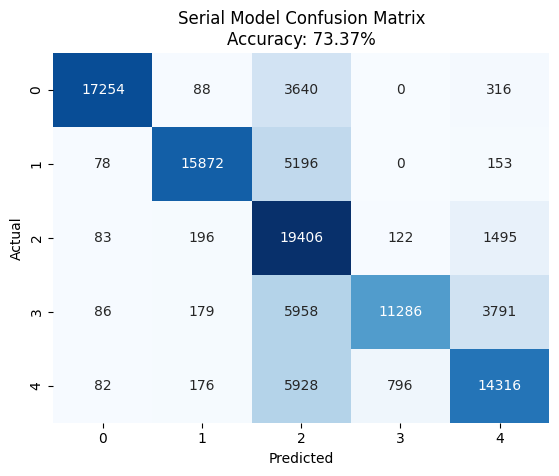

In [54]:
    cm_std = confusion_matrix(metrics['final_true_labels'],metrics['final_predictions'])
    sns.heatmap(cm_std, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Serial Model Confusion Matrix\nAccuracy: {metrics["best_accuracy"]:.2f}%')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

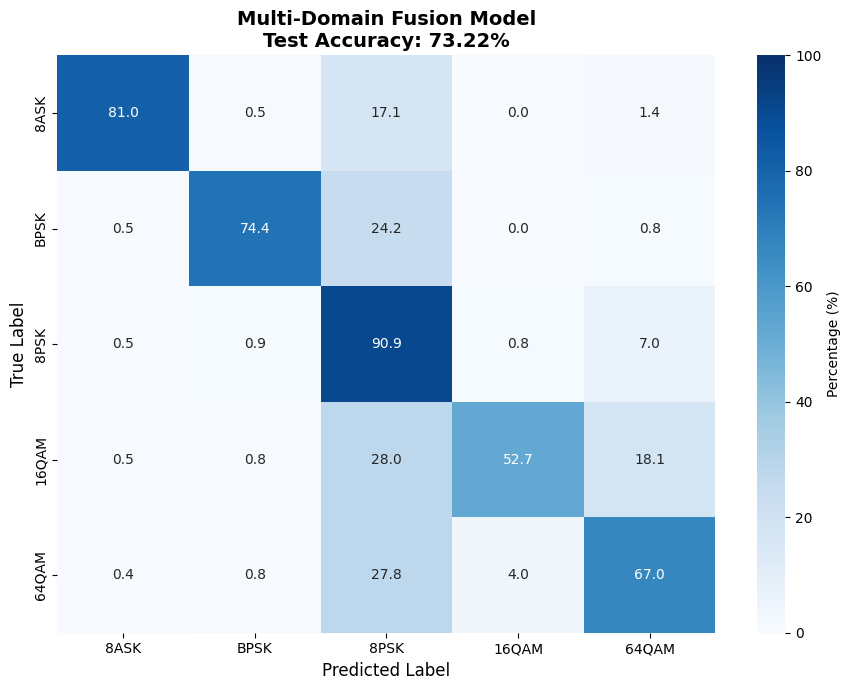

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

def plot_confusion_matrix_percentage(metrics, model_name, class_names=None):
    """
    Plots a confusion matrix for a single model's test results using percentages.

    Args:
        metrics (dict): The metrics dictionary containing test results.
                        Must include 'test_true_labels', 'test_predictions',
                        and 'test_accuracy'.
        model_name (str): The name of the model for the plot title.
        class_names (list, optional): A list of names for the classes.
                                      Defaults to None.
    """
    # --- 1. Validate that the necessary data exists ---
    required_keys = ['test_true_labels', 'test_predictions', 'test_accuracy']
    if not all(key in metrics for key in required_keys):
        print("❌ Error: metrics dictionary is missing required test data.")
        print(f"   Expected keys: {required_keys}")
        return

    # --- 2. Create a single plot ---
    fig, ax = plt.subplots(1, 1, figsize=(9, 7))

    # --- 3. Calculate the confusion matrix ---
    cm = confusion_matrix(
        metrics['test_true_labels'],
        metrics['test_predictions']
    )
    
    # --- 4. Convert to percentages (normalize by true label/row) ---
    # Add a small epsilon to avoid division by zero if a class has no samples
    cm_sum = cm.sum(axis=1)[:, np.newaxis] + 1e-9
    cm_pct = cm.astype('float') / cm_sum * 100

    # --- 5. Plot the heatmap ---
    sns.heatmap(
        cm_pct,
        annot=True,
        fmt='.1f',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names,
        ax=ax,
        cbar_kws={'label': 'Percentage (%)'},
        vmin=0,
        vmax=100
    )

    ax.set_title(f'{model_name}\nTest Accuracy: {metrics["test_accuracy"]:.2f}%', fontsize=14, fontweight='bold')
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    
    plt.tight_layout()
    plt.show()

# --- USAGE EXAMPLE ---
#
# # Assume 'metrics' is the dictionary filled by your single-model training loop
# # Assume TARGET_MODULATIONS is your list of class names
#
plot_confusion_matrix_percentage(
    metrics=metrics,
    model_name="Multi-Domain Fusion Model", # Provide a descriptive name
    class_names=TARGET_MODULATIONS
)


Extracting features from Multi-Domain Fusion model...
Subsampling 2500 data points for t-SNE...
Applying t-SNE... (this may take a moment)


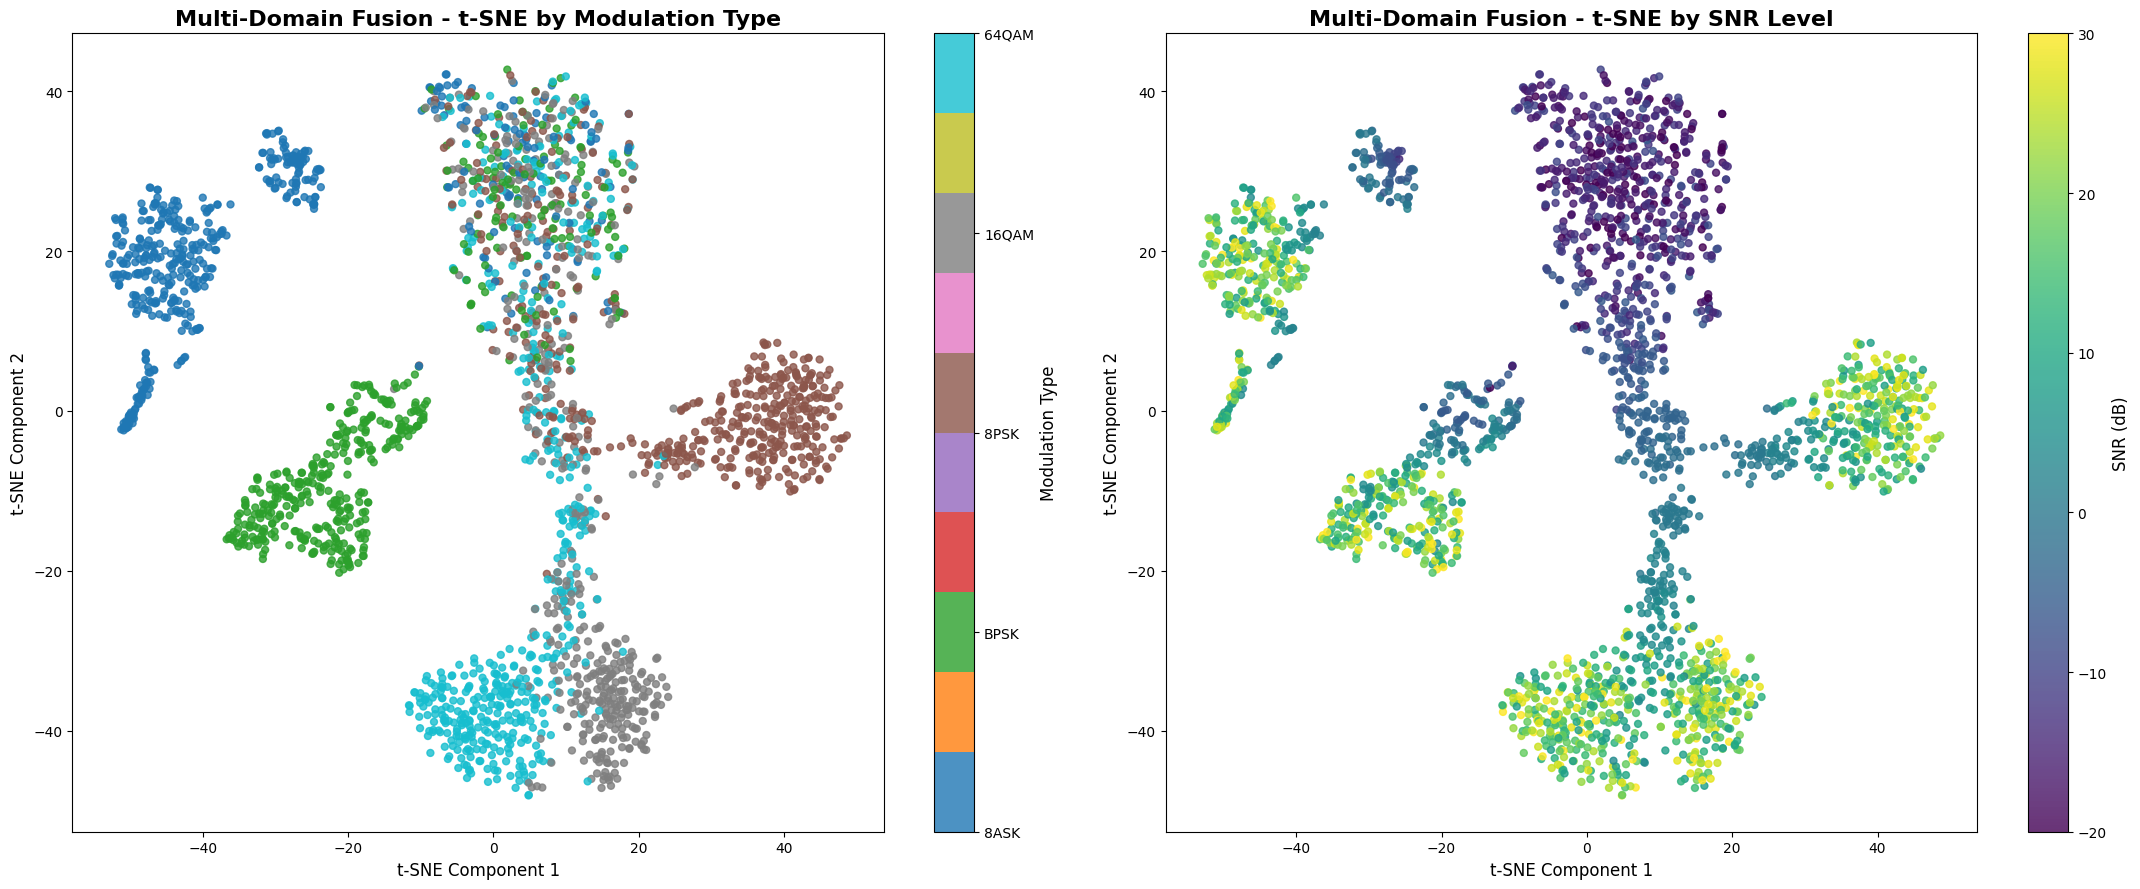

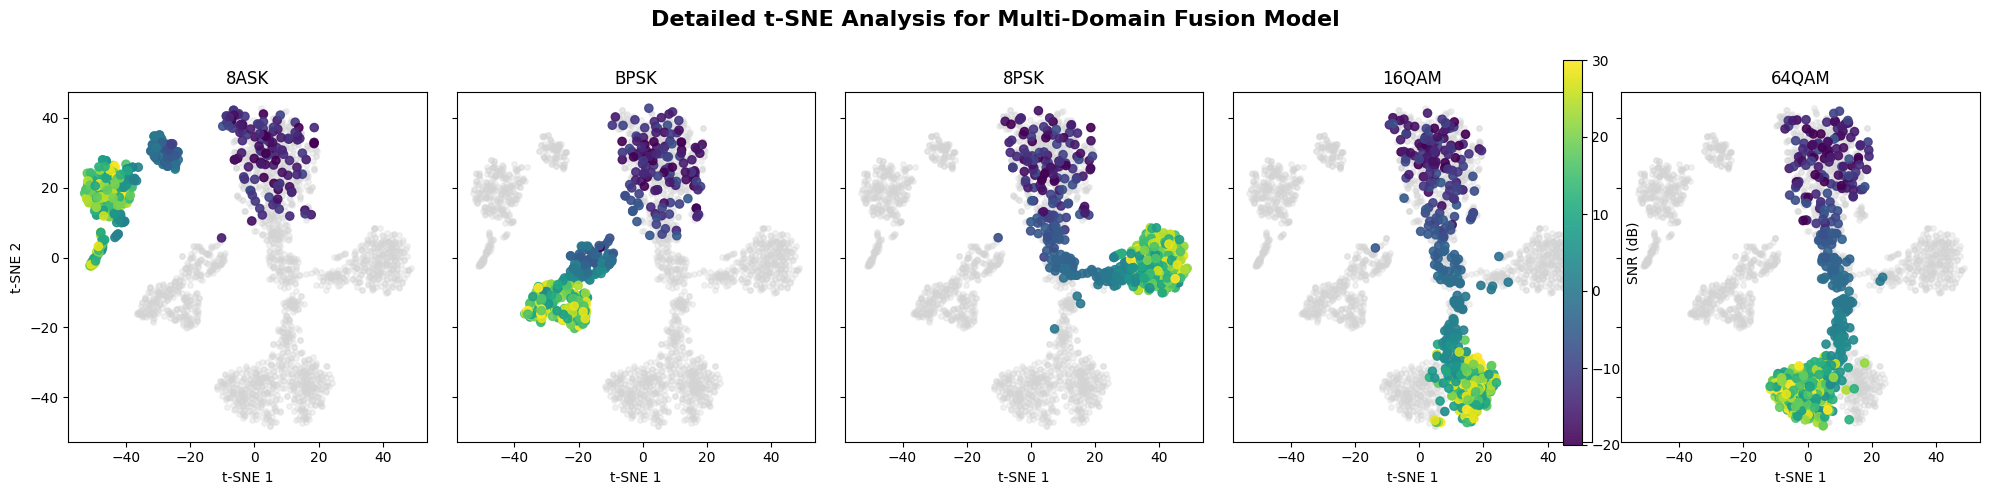

In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

def extract_features_from_model(model, dataloader, device):
    """
    Extract features from the input to the final classifier of the model.
    This version is updated to handle the new 3-input model.

    Args:
        model: PyTorch model with a 'classifier' attribute.
        dataloader: DataLoader containing the data.
        device: Device to run inference on.

    Returns:
        features: Extracted features (numpy array).
        labels: True labels (numpy array).
        snrs: SNR values (numpy array).
    """
    model.eval()
    features_list = []
    labels_list = []
    snrs_list = []

    # This hook captures the INPUT to the specified module.
    # We will hook the classifier to get the final fused feature vector.
    def hook_fn(module, input_tuple, output):
        # The input to a module is a tuple of tensors. We want the first one.
        features_list.append(input_tuple[0].detach().cpu())

    # --- Robust Hook Registration ---
    # This design requires your model to have a final block named 'classifier'.
    if not hasattr(model, 'classifier'):
        raise AttributeError("Model must have a 'classifier' attribute to automatically extract features.")
    
    layer_to_hook = model.classifier
    hook = layer_to_hook.register_forward_hook(hook_fn)

    with torch.no_grad():
        for batch in dataloader:
            # --- ADJUSTMENT: Handle the new 5-item batch from DualStreamRadioMLDataset ---
            if len(batch) == 5:
                amp_inputs, phase_inputs, iq_seq_inputs, labels, snrs = batch
                amp_inputs = amp_inputs.to(device)
                phase_inputs = phase_inputs.to(device)
                iq_seq_inputs = iq_seq_inputs.to(device)
                labels = labels.to(device)
                
                # Forward pass to trigger the hook
                _ = model(amp_inputs, phase_inputs, iq_seq_inputs)
            
            # --- Fallback for old 4-item batch format ---
            elif len(batch) == 4:
                i_inputs, q_inputs, labels, snrs = batch
                i_inputs, q_inputs = i_inputs.to(device), q_inputs.to(device)
                labels = labels.to(device)
                _ = model(i_inputs, q_inputs) # Assumes old model format
            
            else:
                hook.remove() # Clean up hook before raising error
                raise ValueError(f"Unsupported batch size of {len(batch)}. Expected 4 or 5.")

            labels_list.extend(labels.cpu().numpy())
            snrs_list.extend(snrs.cpu().numpy() if hasattr(snrs, 'cpu') else snrs)

    hook.remove()  # IMPORTANT: Always remove the hook after use

    features = torch.cat(features_list, dim=0).numpy()
    
    if len(features.shape) > 2:
        features = features.reshape(features.shape[0], -1)
        
    return features, np.array(labels_list), np.array(snrs_list)

def plot_tsne_visualization(model, model_name, dataloader, device, target_modulations, n_samples=2000):
    """
    Create a t-SNE visualization for a single model's feature representations.
    """
    # --- 1. Extract Features ---
    print(f"Extracting features from {model_name} model...")
    features, labels, snrs = extract_features_from_model(model, dataloader, device)
    
    # --- 2. Subsample for computational efficiency ---
    if len(features) > n_samples:
        print(f"Subsampling {n_samples} data points for t-SNE...")
        indices = np.random.choice(len(features), n_samples, replace=False)
        features = features[indices]
        labels = labels[indices]
        snrs = snrs[indices]

    # --- 3. Apply t-SNE ---
    print("Applying t-SNE... (this may take a moment)")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    tsne_results = tsne.fit_transform(features_scaled)

    # --- 4. Create Plots ---
    fig, axes = plt.subplots(1, 2, figsize=(22, 9))
    
    # Plot 1: Color by modulation type
    ax1 = axes[0]
    scatter = ax1.scatter(tsne_results[:, 0], tsne_results[:, 1],
                          c=labels, cmap='tab10', alpha=0.8, s=25)
    ax1.set_title(f'{model_name} - t-SNE by Modulation Type', fontsize=16, fontweight='bold')
    ax1.set_xlabel('t-SNE Component 1', fontsize=12)
    ax1.set_ylabel('t-SNE Component 2', fontsize=12)
    cbar = fig.colorbar(scatter, ax=ax1, ticks=range(len(target_modulations)))
    cbar.set_ticklabels(target_modulations)
    cbar.set_label('Modulation Type', fontsize=12)
    
    # Plot 2: Color by SNR level
    ax2 = axes[1]
    scatter_snr = ax2.scatter(tsne_results[:, 0], tsne_results[:, 1],
                              c=snrs, cmap='viridis', alpha=0.8, s=25)
    ax2.set_title(f'{model_name} - t-SNE by SNR Level', fontsize=16, fontweight='bold')
    ax2.set_xlabel('t-SNE Component 1', fontsize=12)
    ax2.set_ylabel('t-SNE Component 2', fontsize=12)
    cbar_snr = fig.colorbar(scatter_snr, ax=ax2)
    cbar_snr.set_label('SNR (dB)', fontsize=12)
    
    plt.tight_layout()
    plt.savefig(f'tsne_{model_name}_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

    # --- 5. Create Detailed Analysis Plot ---
    create_detailed_tsne_analysis(tsne_results, labels, snrs, target_modulations, model_name)

def create_detailed_tsne_analysis(tsne_results, labels, snrs, target_modulations, model_name):
    """
    Create detailed t-SNE analysis with per-modulation separation for a single model.
    """
    num_modulations = len(target_modulations)
    fig, axes = plt.subplots(1, num_modulations, figsize=(4 * num_modulations, 5), sharex=True, sharey=True)
    fig.suptitle(f'Detailed t-SNE Analysis for {model_name} Model', fontsize=16, fontweight='bold')

    for mod_idx, modulation in enumerate(target_modulations):
        ax = axes[mod_idx]
        
        # Highlight current modulation
        current_mask = (labels == mod_idx)
        other_mask = (labels != mod_idx)
        
        # Plot other modulations in gray
        ax.scatter(tsne_results[other_mask, 0], tsne_results[other_mask, 1],
                   c='lightgray', alpha=0.3, s=15, label='Other')
        
        # Plot current modulation colored by SNR
        if np.sum(current_mask) > 0:
            scatter = ax.scatter(tsne_results[current_mask, 0], tsne_results[current_mask, 1],
                                 c=snrs[current_mask], cmap='viridis', alpha=0.9, s=35,
                                 label=modulation, vmin=snrs.min(), vmax=snrs.max())
        
        ax.set_title(f'{modulation}', fontsize=12)
        ax.set_xlabel('t-SNE 1')

    # Add a single colorbar for SNR
    fig.colorbar(scatter, ax=axes.ravel().tolist(), label='SNR (dB)', pad=0.01)
    axes[0].set_ylabel('t-SNE 2')
    
    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust for suptitle
    plt.savefig(f'tsne_{model_name}_detailed.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- USAGE EXAMPLE ---
#
# model_new = ... # Your new, trained MultiDomainFusionModel
# model_new.load_state_dict(best_model_state) # Load best weights
#
# test_loader = ... # Your test dataloader from DualStreamRadioMLDataset
# device = ...      # Your device
# TARGET_MODULATIONS = ... # Your list of modulation names
# 
plot_tsne_visualization(
    model=model_new,
    model_name='Multi-Domain Fusion', # A descriptive name for your model
    dataloader=test_loader,
    device=device,
    target_modulations=TARGET_MODULATIONS,
    n_samples=2500
)


Gathering predictions from 'Multi-Domain Fusion' model...


Evaluating Model: 100%|█| 832/832 [00:21<0


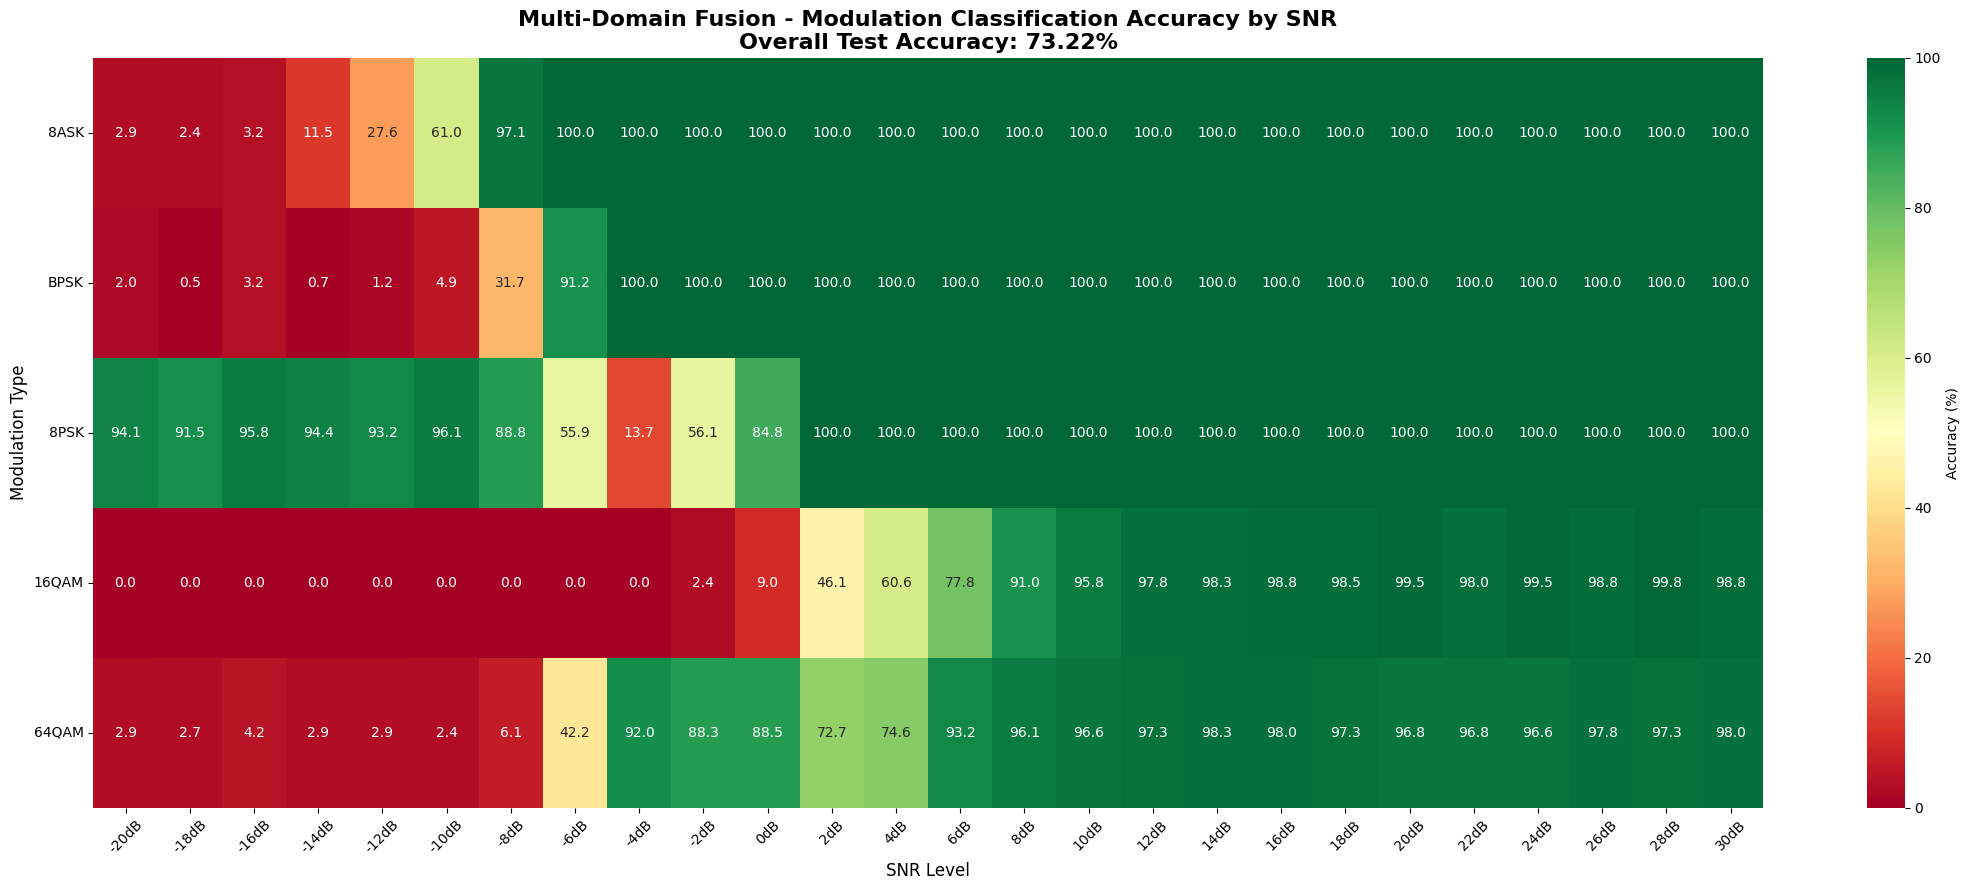

In [57]:
def plot_snr_accuracy_heatmap(model, model_name, dataloader, device, target_modulations):
    """
    Plots a detailed accuracy heatmap for a single model across all modulations and SNR levels.
    This version is adapted for the Multi-Domain Fusion model and its specific data loader.

    Args:
        model: The trained PyTorch model to evaluate.
        model_name (str): A descriptive name for the model for the plot title.
        dataloader: The DataLoader containing the test data.
        device: The device to run inference on.
        target_modulations (list): A list of the modulation class names.
    """
    model.eval()
    all_predictions = []
    all_true_labels = []
    all_snrs = []

    print(f"Gathering predictions from '{model_name}' model...")
    with torch.no_grad():
        # Iterate through the dataloader with a progress bar
        for batch in tqdm(dataloader, desc="Evaluating Model"):
            # --- ADJUSTMENT: Explicitly handle the 5-item batch ---
            amp_inputs, phase_inputs, iq_seq_inputs, labels, snrs = batch
            
            amp_inputs = amp_inputs.to(device)
            phase_inputs = phase_inputs.to(device)
            iq_seq_inputs = iq_seq_inputs.to(device)
            labels = labels.to(device)
            
            # --- ADJUSTMENT: Call the model with its three required inputs ---
            outputs = model(amp_inputs, phase_inputs, iq_seq_inputs)
            
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_true_labels.extend(labels.cpu().numpy())
            all_snrs.extend(snrs.cpu().numpy())

    # --- Create a DataFrame for easy analysis ---
    results_df = pd.DataFrame({
        'true_label': all_true_labels,
        'predicted_label': all_predictions,
        'snr': all_snrs
    })
    
    # --- Calculate the accuracy matrix ---
    unique_snrs = sorted(results_df['snr'].unique())
    accuracy_matrix = np.zeros((len(target_modulations), len(unique_snrs)))

    for i, mod_name in enumerate(target_modulations):
        # The label index corresponds to the modulation index
        mod_label_index = i 
        for j, snr in enumerate(unique_snrs):
            # Filter for the specific modulation and SNR
            subset = results_df[(results_df['true_label'] == mod_label_index) & (results_df['snr'] == snr)]
            if len(subset) > 0:
                # Calculate accuracy for this specific slice of data
                accuracy = (subset['true_label'] == subset['predicted_label']).mean()
                accuracy_matrix[i, j] = accuracy * 100
            else:
                accuracy_matrix[i, j] = 0 # No samples for this combination

    # --- Plot the heatmap ---
    fig, ax = plt.subplots(1, 1, figsize=(22, 9))
    
    overall_accuracy = (results_df['true_label'] == results_df['predicted_label']).mean() * 100
    
    sns.heatmap(
        accuracy_matrix,
        xticklabels=[f'{int(snr)}dB' for snr in unique_snrs],
        yticklabels=target_modulations,
        annot=True,
        fmt='.1f',
        cmap='RdYlGn',
        vmin=0,
        vmax=100,
        cbar_kws={'label': 'Accuracy (%)'},
        ax=ax
    )
    
    ax.set_title(
        f'{model_name} - Modulation Classification Accuracy by SNR\n'
        f'Overall Test Accuracy: {overall_accuracy:.2f}%',
        fontsize=16, fontweight='bold'
    )
    ax.set_xlabel('SNR Level', fontsize=12)
    ax.set_ylabel('Modulation Type', fontsize=12)
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)
    
    plt.tight_layout()
    plt.savefig(f'snr_accuracy_heatmap_{model_name.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()

# --- USAGE EXAMPLE ---
#
# # Assume you have:
# # model_new: Your trained MultiDomainFusionModel
# # test_loader: The DataLoader for your test set
# # device: Your target device
# # TARGET_MODULATIONS: List of class names
#
plot_snr_accuracy_heatmap(
    model=model_new,
    model_name='Multi-Domain Fusion',
    dataloader=test_loader,
    device=device,
    target_modulations=TARGET_MODULATIONS
)
